# ViT - Gabarito

## Configuração

Importando módulos necessários

In [1]:
%load_ext nbproxy

Chave:  f5qn
Senha: ········



Variáveis de ambiente http_proxy e https_proxy configuradas!


In [2]:
# Bibliotecas principais
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# Transformações e manipulação de dados
import torchvision
from torchvision import transforms, models, datasets

# Utilitários de visualização e manipulação de dados
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Divisão de dados e métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


## Introdução

Neste notebook, exploraremos o Vision Transformer (ViT), uma arquitetura baseada em Transformers que tem revolucionado a área de visão computacional. Tradicionalmente, redes neurais convolucionais (CNNs) eram consideradas o padrão para tarefas como classificação de imagens, detecção de objetos e segmentação. No entanto, o ViT demonstrou que Transformers, originalmente projetados para processamento de linguagem natural (NLP), também podem ser altamente eficazes para imagens.

Diferentemente das CNNs, que extraem características por meio de convoluções locais, o ViT trabalha dividindo a imagem em patches (pequenos blocos) e processando-os como uma sequência, semelhante a tokens em NLP. Essa abordagem permite capturar dependências de longo alcance entre regiões da imagem desde as primeiras camadas da rede, por conta do uso do mecanismo de Attention, algo que as CNNs alcançam apenas em camadas mais profundas. Com treinamentos adequados e grandes volumes de dados, o ViT superou as CNNs em várias tarefas de visão computacional.

O objetivo dos exercícios propostos neste notebook é revisitar os conceitos da aula de ViT e analisar como os mesmos problemas vistos no módulo de CNNs se comportam quando resolvidos com Vision Transformers (ViTs). Iniciaremos com um exercício introdutório, no qual retomaremos a tarefa de classificação de imagens no dataset CIFAR-10, já explorada em semanas anteriores, para que entendam e se familiarizem com implementação do modelo. Em seguida, no próximo notebook, avançaremos para um desafio mais complexo: a classificação litológica utilizando outro dataset já visto, o DRP-Benchmarks, especificamente as bases Berea e Grosmont. No módulo de CNNs, essa tarefa foi abordada por meio de uma U-Net para segmentação. Agora, exploraremos como o ViT pode ser aplicado a esse mesmo problema.

## CIFAR-10 Dataset

Definindo argumentos para a implementação do modelo e fazendo o carregamento dos dados, augumentation e outras transformações. Feito de forma similar aos notebooks anteriores da semana de CNNs.

In [3]:
args = {
    'epoch_num': 50,
    'n_classes': 10,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'momentum': 0.9,
    'num_workers': 4,
    'batch_size': 128,
    'w_size': 32, # largura da imagem para redimensionar
    'h_size': 32, # altura da imagem para redimensionar
}
 
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')
 
print(args['device'])

cuda


### Pré-processamento dos dados

In [4]:
root = '/pgeoprj2/ciag2024/dados'

transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # para centrar os dados e facilitar a convergecia
])

data_transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza os valores das imagens
])
 
data_transform2 = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomCrop((75, 75)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5), # Faz um augumentation
])
 
data_transform3 = transforms.Compose([
    transforms.Resize((args['h_size'], args['w_size'])), # Rearranja para o uso no modelo
    transforms.ToTensor(),
])

# Aplico as tranformações
trainset = datasets.CIFAR10(root, train=True, download=True, transform=data_transform1)
testset = datasets.CIFAR10(root, train=False, download=True, transform=data_transform1)
 
trainset = datasets.CIFAR10(root, train=True, download=True, transform=data_transform2)
testset = datasets.CIFAR10(root, train=False, download=True, transform=data_transform2)
 
trainset = datasets.CIFAR10(root, train=True, download=True, transform=data_transform3)
testset = datasets.CIFAR10(root, train=False, download=True, transform=data_transform3)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Definindo o Dataset

#### 1) Crie o ViTDataset
> Carregue todos os dados `testset`, `trainset`, e divida a parte de validação nos dados de treino.

In [5]:
# Crio a Classe Dataset para organizar os dados em treino, teste e validação
class ViTDataset(Dataset):
    def __init__(self, trainset, testset, split, transform=None):

        # 1) Defina self.split
        # 2) Defina self.transform
        # 3) Defina self.dataset de acordo com o split
        # if self.split == 'test':
        #     ...
        # else:
        #     Divida train como 80% e validation como 20%
        #     if self.split == 'train':
        #     elif self.split == 'validation':

        
        # Resposta
        self.split = split
        self.transform = transform
        if self.split == 'test':
            self.dataset = trainset
        else:
            train_size = int(0.8 * len(trainset))
            val_size = len(trainset) - train_size
            train_subset, val_subset = random_split(trainset, [train_size, val_size])
            if self.split == 'train':
                self.dataset = train_subset
            elif self.split == 'validation':
                self.dataset = val_subset

    def __len__(self):
        # Defina

        # Resposta
        return len(self.dataset)

    def __getitem__(self, idx):
        # Defina e aplique a transformação se houver

        # Resposta
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

### Datasets e Dataloaders

In [6]:
# Cria os Datasets
train_vit_dataset = ViTDataset(trainset, testset, "train", transform=transform) 
val_vit_dataset = ViTDataset(trainset, testset, "validation", transform=transform)
test_vit_dataset = ViTDataset(trainset, testset, "test", transform=transform)
 
# Criar os Dataloaders
trainloader = DataLoader(train_vit_dataset, batch_size=args['batch_size'], num_workers=args['num_workers'], shuffle=True)
valloader = DataLoader(val_vit_dataset, batch_size=args['batch_size'], num_workers=args['num_workers'], shuffle=False)
testloader = DataLoader(test_vit_dataset, batch_size=args['batch_size'], num_workers=args['num_workers'], shuffle=False)

### Alguns exemplos do Dataset

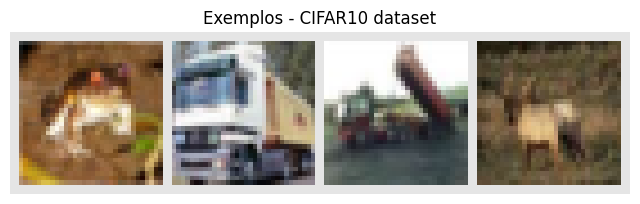

In [7]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Reorganiza o formato da imagem
    plt.show()

# Plotando exemplos do TRAINSET/TESTSET
NUM_IMAGES = 4
IMAGES = torch.stack([trainset[idx][0] for idx in range(NUM_IMAGES)], dim=0)
LABELS = [trainset[idx][1] for idx in range(NUM_IMAGES)]
img_grid = torchvision.utils.make_grid(IMAGES, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Exemplos - CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [8]:
# Verificando um lote do dataloader - tamanhos [batch_size, channels, image_h, image_w] 
for images, labels in trainloader:
    print(images.shape)  # Esperado: [batch_size, channels, image_size, image_size]
    print(labels.shape)  # Esperado: [batch_size]
    break

torch.Size([128, 3, 32, 32])
torch.Size([128])


Agora, a partir daqui temos os dados organizados em um Dataset que gera os Dataloaders que utilizaremos no nosso modelo, de treino, teste e validação. Observe que nosso `ViTDataset` retorna um tensor de formato `[128, 3, 32, 32]`, ou seja, retorna uma imagem inteira `32x32`, de três canais e batch de `128`. Precisamos decidir como cortar essa imagem em patches para passar para nosso ViT posteriormente.

## Como partir as imagens em patches?

Cortar uma imagem em patches para um Vision Transformer (ViT) é uma tarefa relativamente simples, mas requer atenção na escolha do tamanho dos patches. O ideal é selecionar um tamanho que seja divisível pelas dimensões da imagem, garantindo um corte preciso e sem sobreposição. Além disso, os patches não devem ser excessivamente pequenos, pois isso pode resultar na perda de informações relevantes. Encontrar um equilíbrio entre resolução e número de patches é essencial para que o modelo capture bem os padrões visuais. Abaixo há uma função de corte de referência, mas que serve mais de exemplo para a visualização dessas técnica.

Label da imagem: 9 (truck)


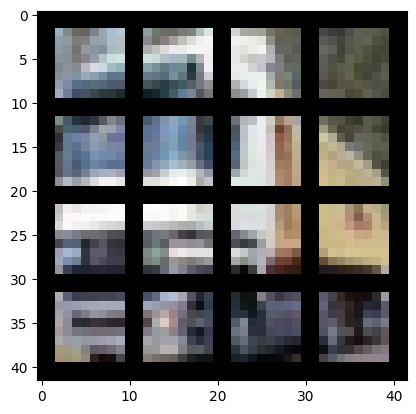

In [9]:
def image_to_patches(image, patch_size=8): # Apenas para visulização
    patches = []
    for i in range(0, image.size(1), patch_size):
        for j in range(0, image.size(2), patch_size):
            patch = image[:, i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return torch.stack(patches) # Retorna um tensor [16, 3, 8, 8] -> [num_de_patches, canais, patch_h, patch_w]
 
def imshow_patches(patches, grid_size=(4, 4)):
    patches_grid = torchvision.utils.make_grid(patches, nrow=grid_size[1]) 
    imshow(patches_grid)
 
class_names = trainset.classes # dicionário de número da label p/ nome da label
patches = image_to_patches(IMAGES[1])
label = LABELS[1]
print(f"Label da imagem: {label} ({class_names[label]})")  # Imprimir o número da label e o nome da classe
imshow_patches(patches)


## Transformers para classificação de imagens  

Transformers são um tipo de arquitetura de rede neural baseada em mecanismos de atenção (principalmente self-attention) para processar sequências de dados de forma eficiente. Eles foram introduzidos no artigo ["Attention Is All You Need" (2017)](https://arxiv.org/abs/1706.03762) e revolucionaram o processamento de linguagem natural (PLN) e visão computacional. Diferente de redes recorrentes (RNNs), os Transformers processam tokens em paralelo, tornando o treinamento mais rápido e eficiente. Seu principal componente, o mecanismo de atenção, permite que cada elemento da sequência "preste atenção" em outros elementos, capturando relações de longo alcance. Mas por que não aplicar essa mesma ideia em imagens?  

Foi exatamente isso que Alexey Dosovitskiy et al. propuseram no artigo ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://openreview.net/pdf?id=YicbFdNTTy). O **Vision Transformer (ViT)** trata imagens como sequências de pequenos **patches**. Por exemplo, uma imagem de 48×48 pixels pode ser dividida em 9 patches de 16×16 pixels. Cada patch é tratado como um **token**, projetado para um espaço de características. Ao adicionar codificações posicionais e um token de classificação, podemos aplicar um Transformer nessa sequência e treiná-lo para a tarefa de classificação de imagens.  

Abaixo, uma animação ilustra essa ideia ([Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)):  

<!-- ![Vision Transformer gif](https://github.com/lucidrains/vit-pytorch/raw/main/images/vit.gif)  -->
<div style="text-align: center;">
    <img src="https://github.com/lucidrains/vit-pytorch/raw/main/images/vit.gif" alt="Vision Transformer gif" width="600">
</div>

Aqui focaremos na parte do Encoder do Transformer, nele utiliza-se o mecanismo de atenção para extrair representações complexas de dados, como imagens ou textos. Esse mecanismo permite que o modelo foque nas partes mais relevantes da entrada, capturando as características essenciais para a tarefa. Após a extração das features, o Transformer pode ser combinado com diferentes tipos de cabeças (heads). No exemplo mostrado acima, a cabeça de classificação é representada por uma MLP (perceptron multicamadas), que atua como um classificador para a tarefa específica, mas pode até mesmo ser integrados com decoders, como já visto, para tarefas como tradução e geração de texto por exemplo.

Sua flexibilidade permite que o Transformer seja facilmente adaptado para diversas tarefas, como classificação, segmentação e modelos multimodais que combinam dados textuais e visuais. Essa versatilidade torna o Transformer uma ferramentaamplamente utilizada no cenário atual, capaz de ser integrada com outras arquiteturas de redes neurais, resultando em modelos mais complexos, versáteis e poderosos.


## Implementação de um Visual Transformer

### 2) Defina a função para cortar a imagem em patches
> Implemente uma função de "image to patch". Não é recomendado tentar reutilizar a função de exemplo anterior, pois seguindo o modelo abaixo é mais intuitivo e simples.

<div style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*cnbRaydTbaTJK2-Q7DAJBA.png" alt="Vision Transformer gif" width="600">
</div>

Como fazer: Imagine que você possui uma imagem de tamanho `32x32` e deseja dividi-la em patches. Primeiramente teríamos `B, C, H, W = image.shape` como formato da imagem, e vamos dividí-la conforme patches de tamanho `patch_size_h` por `patch_size_w`, resultando em `[B, C, H // patch_size_h, patch_size_h, W // patch_size_w, patch_size_w]`, Isso cria uma "grade" de patches dentro da imagem, mas esse formato não é conveniente para alimentar um ViT, pois o modelo precisa que os patches sejam representados como vetores em uma sequência de entradas. Para isso reorganizamos o formato para `[B, H', W', C, patch_H, patch_W]`, com `H'` e `W'` como o número de patches na altura e largura, e depois unimos, `[B, H' * W', C * patch_H * patch_W]`, de forma que temos o `batch_size`, `num_patches`, o vetor que representa um patch.


In [10]:
def img_to_patch(x, patch_size):

    # 0) Defina x.shape
    # 1) .reshape para deividir em patches
    # 2) .permute para reorganizar o vetor
    # 3) .flatten para unir valores

    # Resposta:
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) 
    x = x.flatten(1,2)
    x = x.flatten(2,4)
    
    return x

### 3) Defina a Camada do Transformer

Aqui será feita a atenção uitlizando o `MultiheadAttention` já visto com detalhes anteriormente. A ideia aqui é fazer a normalização pré-layer, isso é apenas uma decisão de implementação, mas que de acordo com [Ruibin Xionget al.](https://arxiv.org/abs/2002.04745) em 2020. A ideia é aplicar a Layer Normalization não entre os blocos residuais, mas sim como a primeira camada dentro desses blocos. Essa reorganização das camadas ajuda a melhorar o fluxo dos gradientes. Essa ideia é apresentada na imagem abaixo:

<div style="text-align: center;">
    <img src="../../images/Layer_Normalization.png" alt="Vision Transformer gif" width="300">
</div>

In [11]:
class TransformerLayer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()

        # 1) Defina uma norm_layer1 que recebe (embed_dim)
        # 2) Defina uma camada de atenção
        # 3) Defina uma norm_layer2 que recebe (embed_dim)
        # 4) Defina uma sequência de operações lineares e função de ativação (ReLU ou GELU) e dropout

        # Resposta:
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, 
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
        
    def forward(self, x):
        # 1) Defina o "forward" da rede, lembre-se de usar uma variável para guardar o a saída da primeira camada (norm_layer) para usá-la no Attention

        # Resposta:
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

### 4) Defina o ViT Transformer

<div style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*qab5J7abx-XTNf9CPJ15dw.png" alt="Vision Transformer gif" width="600">
</div>

A implementação do **Vision Transformer (ViT)** pode ser resumida em:

1. **Inicialização do Modelo (`__init__`)**:
   - **`input_layer`**: Converte os patches das imagens em embeddings com dimensionalidade `embed_dim`.
   - **`transformer`**: Composto por várias camadas de **TransformerLayer** que aplicam o mecanismo de atenção para capturar interações entre os patches.
   - **`mlp_head`**: Camada de normalização (`LayerNorm`) seguida de uma camada linear para gerar a previsão da classe com `num_classes` saídas.
   - **`dropout`**: Regularização aplicada tanto no feed-forward quanto nas codificações de entrada.
   - **Embeddings**: Usa um **token de classe (`cls_token`)** e **embedding posicional (`pos_embedding`)** para representar informações globais e espaciais.
> Obs: fazemos um *positional embedding* simples, que será aprendido. $ PE \in \mathbb{R}^{(1 + N) \times D} $

2. **`forward`**:
   - **Pré-processamento de Entrada**: A função `img_to_patch` converte a imagem em uma sequência de patches.
   - **Token de Classe e Embedding Posicional**: O token de classe é concatenado aos patches, e o embedding posicional é somado para fornecer informações de posição.
   - **Aplicação do Transformer**: A sequência de patches passa pelas camadas de Transformer, onde o mecanismo de atenção captura as interações entre eles.
   - **Classificação**: O token de classe, após a aplicação do Transformer, é utilizado para a previsão final da classe.

Essa estrutura permite que o modelo capture as dependências espaciais das imagens, oferecendo uma alternativa eficiente para tarefas de visão computacional, especialmente quando treinado com grandes conjuntos de dados.


In [12]:
class VisionTransformer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        super().__init__()

        # 1) Defina:
        #     - self.patch_size
        #     - self.input_layer -> (vetor_do_patch, embed_dim)
        #     - self.transformer -> Sequential de TransformerLayer's
        #     - self.mlp_head -> mlp simples
        #     - self.dropout
        #     - self.cls_token
        #     - self.pos_embedding -> batch = 1, patches + 1 (cls), embed_dim


        # Resposta:
        self.patch_size = patch_size
        
        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[TransformerLayer(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential( # MLP HEAD
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)
        
        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))
    
    
    def forward(self, x):

        # 1) Faça "img_to_patch"
        # 2) Defina algo para x.shape
        # 3) Adicione o token CLS (adiciona batch com .repeat) + Positional Encoding
        # 4) Faça self.dropout + x.transpose(0, 1)
        # 5) Passe para o tranformer
        # 6) Classificação:
        #     - Pegue o CLS
        #     - Classifique-o com MLP
            


        # Resposta
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape # x tem tamanho (32, 16, 192) -> (B, Num_patches, C*patch_size*patch_size)
        x = self.input_layer(x) # x tem tamanho (32, 16, 256) -> embed_dim = 256
        
        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]
        
        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)
        
        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        
        return out

In [13]:
images, labels = next(iter(trainloader))  # Exemplo de pegar o próximo batch
model = VisionTransformer(embed_dim=256, hidden_dim=512, num_channels=3, num_heads=8, num_layers=6, num_classes=args['n_classes'], patch_size=8, num_patches=16, dropout=0.2)
print(model)

VisionTransformer(
  (input_layer): Linear(in_features=192, out_features=256, bias=True)
  (transformer): Sequential(
    (0): TransformerLayer(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=512, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): TransformerLayer(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): 

In [14]:
output = model(images)
print(output.shape)  # Esperado [batch_size, num_classes]

torch.Size([128, 10])


## Treinamento e Avaliação (Exemplo básico)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
criterion = nn.CrossEntropyLoss()


Época 1/30
Perda de treino: 1.8664, Acurácia: 0.3163, Precisão: 0.3095, Revocação: 0.3163, F1-score: 0.3095
Perda de teste: 1.5990, Acurácia: 0.4266, Precisão: 0.4408, Revocação: 0.4266, F1-score: 0.4225

Época 2/30
Perda de treino: 1.5707, Acurácia: 0.4366, Precisão: 0.4314, Revocação: 0.4366, F1-score: 0.4324
Perda de teste: 1.4378, Acurácia: 0.4870, Precisão: 0.5043, Revocação: 0.4870, F1-score: 0.4826

Época 3/30
Perda de treino: 1.4570, Acurácia: 0.4794, Precisão: 0.4746, Revocação: 0.4794, F1-score: 0.4757
Perda de teste: 1.3464, Acurácia: 0.5198, Precisão: 0.5316, Revocação: 0.5198, F1-score: 0.5161

Época 4/30
Perda de treino: 1.3922, Acurácia: 0.5001, Precisão: 0.4954, Revocação: 0.5001, F1-score: 0.4967
Perda de teste: 1.2915, Acurácia: 0.5435, Precisão: 0.5550, Revocação: 0.5435, F1-score: 0.5408

Época 5/30
Perda de treino: 1.3418, Acurácia: 0.5199, Precisão: 0.5154, Revocação: 0.5199, F1-score: 0.5167
Perda de teste: 1.2210, Acurácia: 0.5677, Precisão: 0.5685, Revocação: 

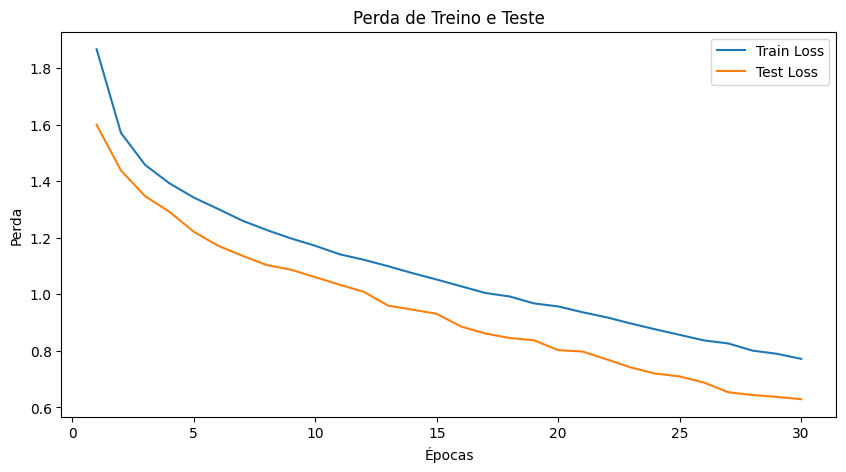

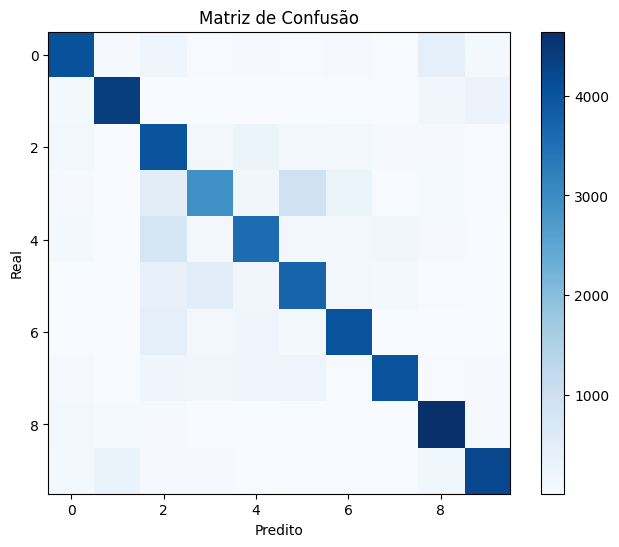

In [16]:
# Definir dispositivo
device = args['device']
model.to(device)

# Listas para armazenar as perdas e métricas
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(model, trainloader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    accuracy = total_correct / total_samples
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    avg_loss = total_loss / len(trainloader)
    
    print(f"Perda de treino: {avg_loss:.4f}, Acurácia: {accuracy:.4f}, Precisão: {precision:.4f}, Revocação: {recall:.4f}, F1-score: {f1:.4f}")
    return avg_loss, accuracy, precision, recall, f1

def evaluate(model, testloader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = total_correct / total_samples
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    avg_loss = total_loss / len(testloader)
    
    print(f"Perda de teste: {avg_loss:.4f}, Acurácia: {accuracy:.4f}, Precisão: {precision:.4f}, Revocação: {recall:.4f}, F1-score: {f1:.4f}")
    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds

# Exemplo de treinamento
num_epochs = 30
for epoch in range(num_epochs):
    print(f"\nÉpoca {epoch+1}/{num_epochs}")
    train_loss, train_acc, train_prec, train_rec, train_f1 = train(model, trainloader, optimizer, criterion)
    test_loss, test_acc, test_prec, test_rec, test_f1, all_labels, all_preds = evaluate(model, testloader, criterion)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotar o gráfico de perdas
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.title('Perda de Treino e Teste')
plt.legend()
plt.show()

# Plotar a matriz de confusão
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## Conclusões

Os Vision Transformers (ViTs) são projetados para lidar com tarefas de classificação em larga escala, onde há uma abundância de dados para treinamento. Diferente das CNNs, que exploram a estrutura local das imagens através de convoluções com pesos compartilhados, os ViTs processam a entrada como uma sequência de patches e dependem exclusivamente do mecanismo de atenção para capturar relações espaciais. Essa abordagem, embora poderosa, exige uma quantidade substancial de dados para evitar problemas como overfitting e para permitir que o modelo aprenda representações significativas sem a indutividade estrutural das CNNs.

No caso do CIFAR-10, um dataset relativamente pequeno com imagens de 32x32 pixels, torna os ViTs menos eficientes quando treinados do zero. Sem um pré-treinamento em um conjunto de dados maior, o ViT demora mais para convergir e frequentemente apresenta um desempenho inferior em relação às CNNs, que são naturalmente adequadas para esse tipo de tarefa devido à sua capacidade de captar padrões locais desde as primeiras camadas. Como esperado, os resultados preliminares mostraram que o ViT não foi muito bom em eficácia, alcançando uma convergência mais demorada ede menor desempenho com um volume de dados reduzido. No entanto, mesmo nessas condições adversas, o ViT ainda foi capaz de alcançar métricas e perdas boas, com mais épocas, o que demonstra seu potencial.